# Analyse TF-IDF du df_final

1. **Réaliser un TF-IDF** sur l'ensemble des `cases_texte` du `df_final`.
2. **Tenter de prédire** la colonne `major_mesh_terms` à partir du TF-IDF.

In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)


In [57]:
df = pd.read_csv('data/df_target')
df_metadata = pd.read_parquet('data/df_metadata')

import os
import s3fs

# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_OUT = "s3://quentin1999/Data_Projet_NLP"
FILE_KEY_OUT_S3 = "df_final"
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + FILE_KEY_OUT_S3

with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    df.to_parquet(file_out)

BUCKET_OUT = "s3://quentin1999/Data_Projet_NLP"
FILE_KEY_OUT_S3 = "df_metadata"
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + FILE_KEY_OUT_S3

with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    df_metadata.to_csv(file_out)

## Afficher nuage de mot avec WordCloud

In [33]:
df.shape

(500, 13)

In [34]:
text_brut = str(df['case_text'])

In [35]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')


#stop_words = set(stopwords.words('english'))
#text_brut = [word for word in text_brut if word not in stop_words]

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

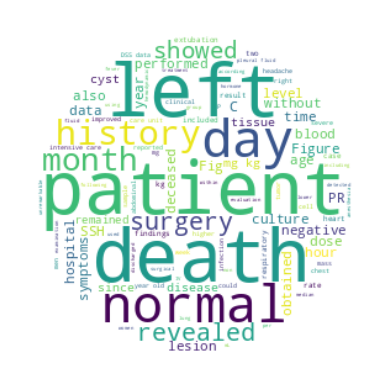

In [6]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes


STOPWORDS = set(stopwords.words('english'))

import matplotlib.pyplot as plt
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# plot a word cloud
text = str(df['case_text'])
wc = WordCloud(background_color="white", repeat=True, mask=mask, stopwords = STOPWORDS)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [7]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:
# Load the Med7 model
nlp = spacy.load("en_core_web_sm")

text = " ".join(df['case_text'].astype(str)) 

# Extraction des entités nommées pertinentes (si tu veux des termes médicaux spécifiques, SciSpaCy serait meilleur)
medical_terms = []

for doc_text in df['case_text'].astype(str):
    doc = nlp(doc_text)
    medical_terms.extend([ent.text for ent in doc.ents])


# Ajoute des mots personnalisés (optionnel)
additional_terms = ["one", "two", "three", "day", "daily", "month"]
medical_terms.extend(additional_terms)

# Extract medical terms
medical_bagofwords = " ".join(medical_terms)
print(medical_terms)

# plot a word cloud
wc = WordCloud(background_color="white", repeat=True, mask=mask, stopwords = STOPWORDS)
wc.generate(medical_bagofwords)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

KeyboardInterrupt: 

## Bag-of-word representation

In [58]:
df = pd.read_csv('data/df_target')

In [59]:
from sklearn.model_selection import train_test_split

# Split the dataset, create X (features) and y (target), print the size
data_train, data_dev_test = train_test_split(df ,test_size=0.20, random_state=42)
data_dev, data_test = train_test_split(data_dev_test ,test_size=0.5, random_state=42)

print ('train size',data_train.shape)
print ('dev size', data_dev.shape)
print ('test size', data_test.shape)
# create features X and target y
X_train = data_train.case_text
X_dev = data_dev.case_text
X_test = data_test.case_text
y_train = data_train.target
y_dev = data_dev.target
y_test = data_test.target

train size (8574, 13)
dev size (1072, 13)
test size (1072, 13)


In [60]:
from sklearn.feature_extraction.text import CountVectorizer

document = df.case_text

vectorizer = CountVectorizer(max_features=1000)

# fit on train data
vectorizer.fit(X_train)

# Apply it on train and dev data
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)

In [61]:
vectorizer

CountVectorizer(max_features=1000)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Initiate the model
# Définition du modèle multi-label simple avec Logistic Regression
model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Train
model.fit(X_train_counts, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [69]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur les données de test
y_pred = model.predict(X_test_counts)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# Affichage des résultats
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")

# Rapport complet de classification
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.1343
F1 Score (Macro): 0.0273
F1 Score (Micro): 0.1343
Classification Report:
                                                        precision    recall  f1-score   support

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]       0.15      0.36      0.21        70
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]       0.14      0.20      0.17        10
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]       0.50      0.33      0.40         3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]       0.00      0.00      0.00         2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]       0.00      0.00      0.00        11
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]       0.00      0.00      0.00         1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]       0.00      0.00      0.00         1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]       0.00      0.00      0.00         3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_

In [72]:
# Conversion en numpy arrays 2D
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_array = y_pred if isinstance(y_pred, np.ndarray) else y_pred.toarray()

# Vérifie tes dimensions (doit être [n_samples, n_classes])
print("Dimensions y_test :", y_test_array.shape)
print("Dimensions y_pred :", y_pred_array.shape)

# Calcul généralisé corrigé
generalized_score = np.mean(np.sum(y_test_array == y_pred_array, axis=1))

print(f"Generalized MSE-like Score: {generalized_score:.4f}")

Dimensions y_test : (1072,)
Dimensions y_pred : (1072,)


AxisError: axis 1 is out of bounds for array of dimension 1

In [74]:
print(y_test_array)

['[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]'
 '[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]'
 '[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]' ...
 '[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]'
 '[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]'
 '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]']


In [45]:
for i in range(len(y_pred)):
    print(y_pred[i], " VS ", y_test[i])

KeyError: 0